In [ ]:
import csv
from collections import defaultdict
from datetime import datetime
import plotly.graph_objects as go

def process_conditions_data(file_path):
    """
    Processes condition data from a CSV file to compute time differences between
    consecutive condition records for each patient.
    
    Parameters:
        file_path (str): The path to the CSV file.

    Returns:
        defaultdict: A dictionary mapping pairs of conditions to the list of time differences.
    """
    journey_time_diffs = defaultdict(list)
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        previous_start_date = None
        previous_description = None
        previous_patient = None

        for row in reader:
            start_date = datetime.fromisoformat(row['START'])
            patient = row['PATIENT']
            description = row['DESCRIPTION']

            if previous_start_date is not None and previous_patient == patient:
                time_diff = (start_date - previous_start_date).days
                journey_key = (previous_description, description)
                journey_time_diffs[journey_key].append(time_diff)

            previous_start_date = start_date
            previous_description = description
            previous_patient = patient

    return journey_time_diffs

def calculate_total_and_average_time(journey_time_diffs):
    """
    Calculates the total and average time differences for each journey type.

    Parameters:
        journey_time_diffs (dict): Dictionary of journey types and their respective time differences.

    Returns:
        dict: A dictionary with journey types as keys and a dictionary of total and average times as values.
    """
    times = {}
    for journey_key, time_diffs in journey_time_diffs.items():
        total_time = sum(time_diffs)
        average_time = total_time / len(time_diffs) if time_diffs else 0
        times[journey_key] = {'average': average_time, 'total': total_time}
    return times

def create_sankey_diagram(journey_data, output_file_path):
    """
    Creates and saves a Sankey diagram based on the provided journey data.

    Parameters:
        journey_data (dict): The journey data with total times for transitions.
        output_file_path (str): The path to save the HTML file with the diagram.
    """
    labels = []
    source = []
    target = []
    value = []
    colors = []  # List to store colors for each link
    label_map = {}

    # Specific color palette
    color_palette = [
        '#0077BB',  # Vivid Blue
        '#33BBEE',  # Very Light Blue
        '#009988',  # Vivid Teal
        '#EE7733',  # Vivid Orange
        '#CC3311',  # Vivid Red
        '#EE3377',  # Vivid Pink
        '#BBBBBB'   # Very Light Gray
    ]

    # Map labels and prepare source, target, value lists for Sankey diagram
    for i, ((from_cond, to_cond), data) in enumerate(journey_data.items()):
        for cond in [from_cond, to_cond]:
            if cond not in label_map:
                label_map[cond] = len(labels)
                labels.append(cond)

        source.append(label_map[from_cond])
        target.append(label_map[to_cond])
        value.append(data['total'])
        colors.append(color_palette[i % len(color_palette)])  # Assign color cyclically from palette

    # Define and style the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15, 
            thickness=20, 
            line=dict(color="black", width=0.5), 
            label=labels,
            color=colors  # Optional: define individual node colors if needed
        ),
        link=dict(
            source=source, 
            target=target, 
            value=value, 
            color=colors)
    )])
    fig.update_layout(
        title_text="Sankey Diagram of Patient Condition Journeys",
        font=dict(size=16, color='black'),  # Set global font size and color
        title_font=dict(size=18, color='black')  # Optionally set a different font size for the title
    )
    fig.write_html(output_file_path)
    fig.show()

def main():
    """
    Main function to orchestrate the processing, calculation, and visualization of patient journeys.
    """
    conditions_file_path = 'C:/dataset/conditions_time_fixed.csv'
    journey_time_diffs = process_conditions_data(conditions_file_path)
    times = calculate_total_and_average_time(journey_time_diffs)
    output_file_path = 'C:/dataset/sankey_diagram.html'
    create_sankey_diagram(times, output_file_path)

if __name__ == "__main__":
    main()

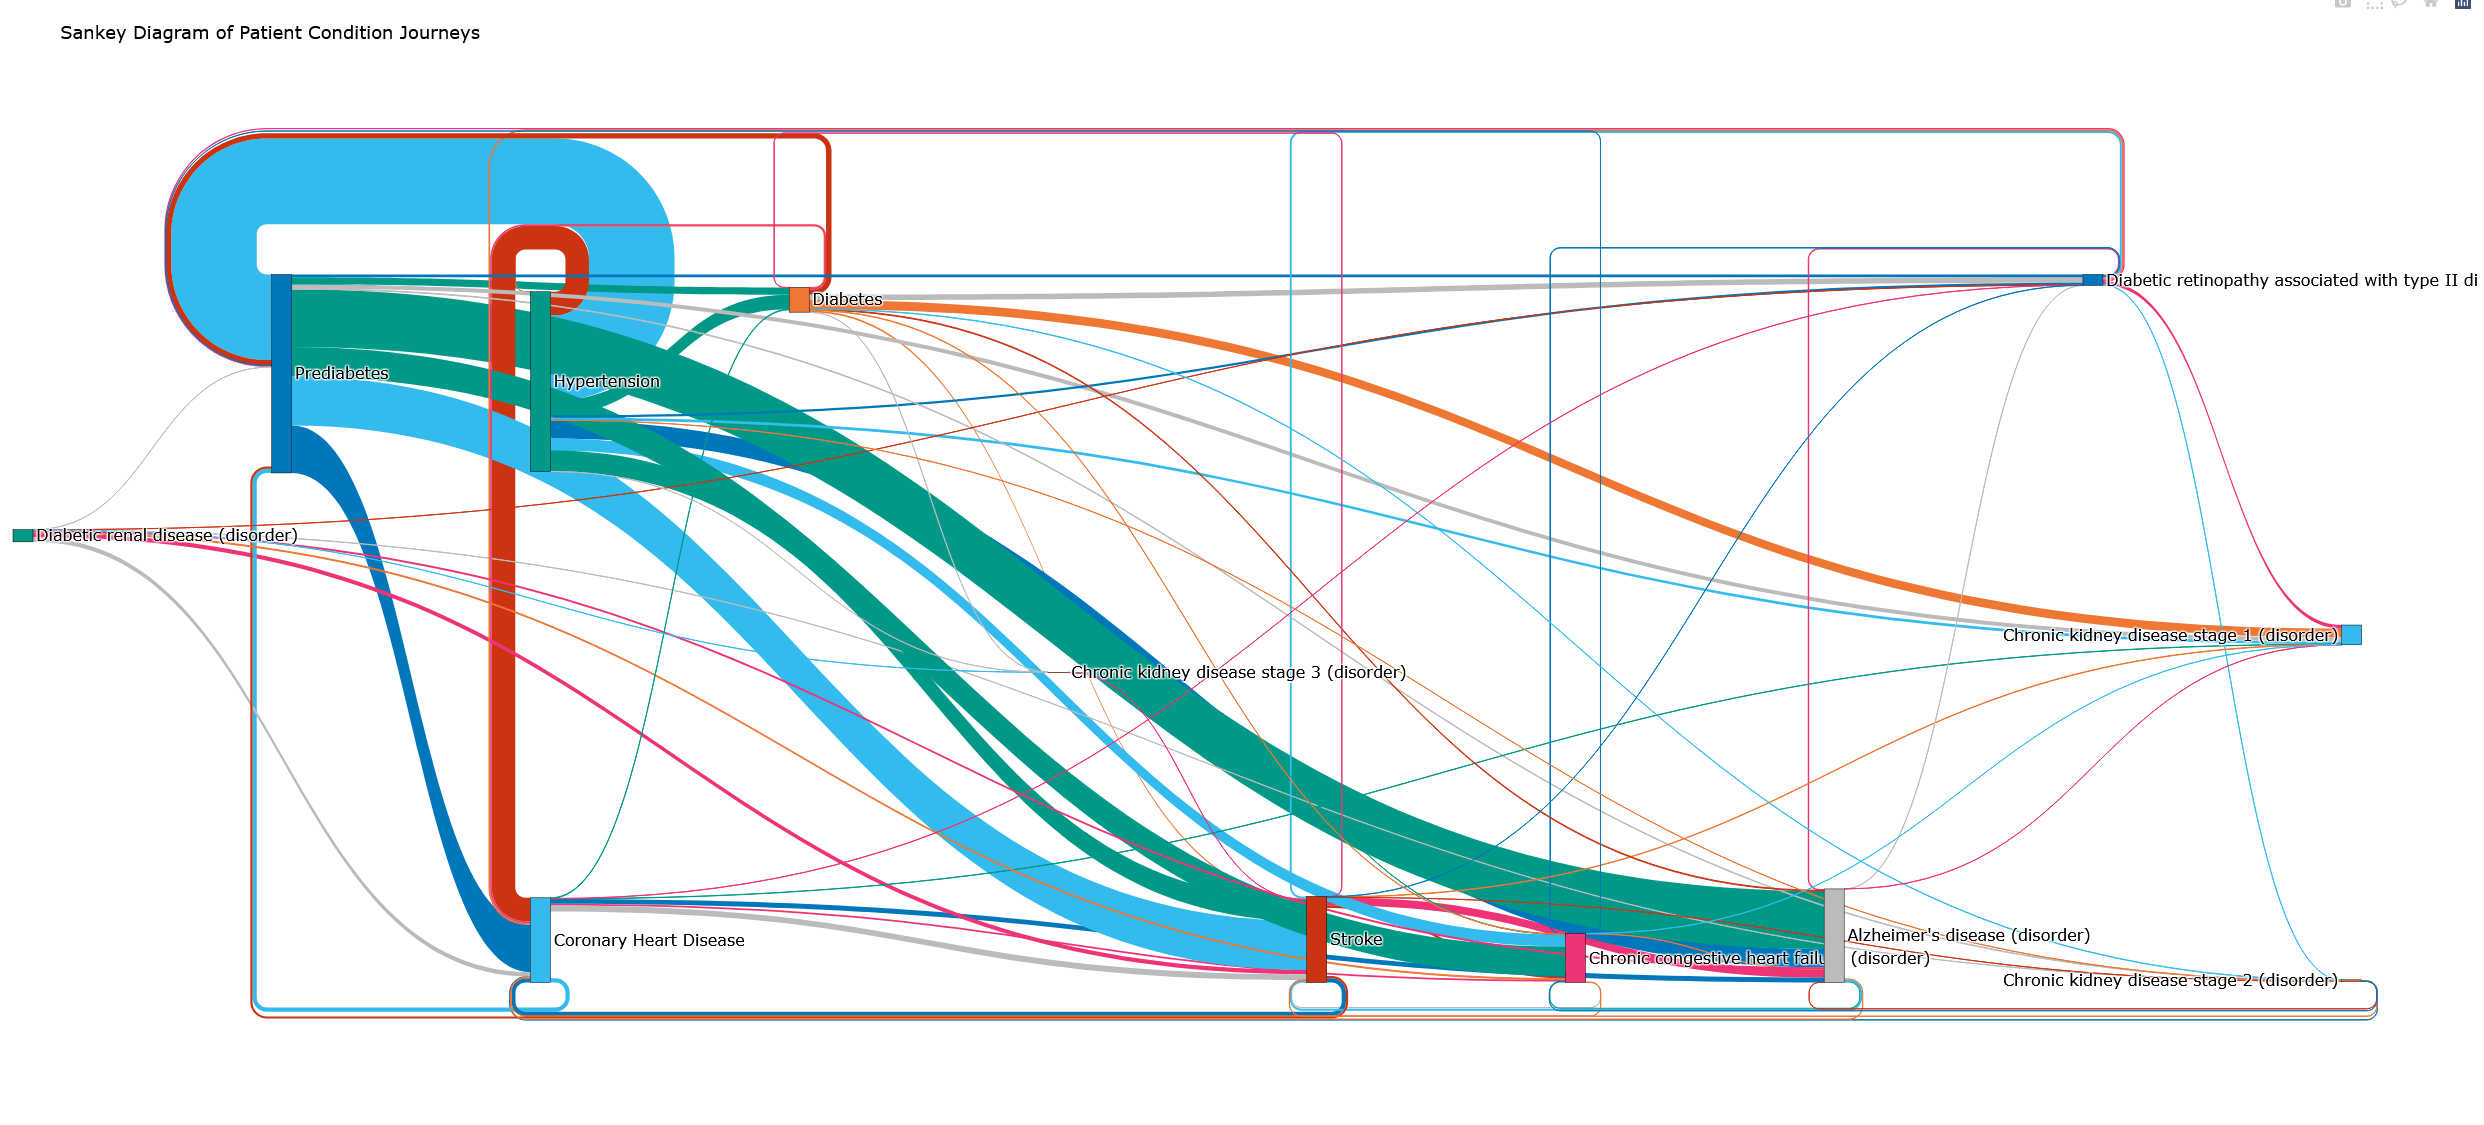